## 1) Classification of NBA players role

## IMPORTANT: make sure to rerun all the code from the beginning to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebook!

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the Kaggle dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains 3 features, the height, the weight and the age.

From Wikipedia (if you are not a basketball fan!!):

The Center (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

Point Guards (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 


As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we will exploit this features to estimate the role.


### Three features are considered for this dataset:


1) Height in cm

2) Weight in kg

3) Age in years

We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron
Firstly we will implement the perceptron algorithm and use it to learn a halfspace.

Load the dataset and then split in training set and test set (the training set is typically larger, you can use a 70% tranining 30% test split) after applying a random permutation to the datset.

A) Load dataset and perform permutation

In [3]:
#load the dataset
filename = 'NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
print(m)
permutation = np.random.permutation(m) # random permurtation

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']
260


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

In [4]:
#m_training needs to be the number of samples in the training set
m_training = int(m*0.7)
print('Number of elements in a training set:',m_training)


m_test = m - m_training #in this case of 260 players it exactly equals to 30%,
#in other possible cases where it's impossible to divide and get an integer it's approximately 30%

print('Number of elements in a test set:', m_test)


def making_training(X, Y, m_training, m): #this is a function that makes everything needed in this part
    trainX = []
    trainY = []
    testX = []
    testY = []
    for_check1 = 9
    for_check2 = 9
    
    while for_check1 < 10 or for_check2 < 10:
        rand_position = []
        
        while len(rand_position) < m_training:
            i = np.random.randint(0,m)
            if i not in rand_position: rand_position.append(i)
                
        for pos in rand_position:
            trainX.append(X[pos])
            trainY.append(Y[pos])
        trainX = np.asarray(trainX)
        trainY = np.asarray(trainY)
        
        maskY1 = (trainY < 0)
        for_check1 = np.prod(trainY[maskY1].shape)
        maskY2 = (trainY > 0)
        for_check2 = np.prod(trainY[maskY2].shape)
        if for_check1 < 10 or for_check2 < 10:
            permutation = np.random.permutation(m) # random permurtation
            X = X[permutation]
            Y = Y[permutation]
            
    #it is a final number of -1 and 1 data in our training set
    print('Number of -1 in training set:', for_check1)
    print('Number of 1 in training set:', for_check2)
    
    test_position = [i for i in range(m) if i not in rand_position]
    
    for pos in test_position:
            testX.append(X[pos])
            testY.append(Y[pos])
    testX = np.asarray(testX)
    testY = np.asarray(testY)
        
    return trainX, trainY, testX, testY


X_training, Y_training, X_test, Y_test =  making_training(X,Y,m_training,m)

print('Y_training:', Y_training) #to make sure that Y_training contains both 1 and -1
print(m_test)

print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))

Number of elements in a training set: 182
Number of elements in a test set: 78
Number of -1 in training set: 78
Number of 1 in training set: 104
Y_training: [-1  1  1 -1  1  1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1  1 -1 -1  1  1  1
  1  1 -1  1  1 -1  1  1 -1 -1  1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1
  1 -1  1  1 -1  1  1  1 -1  1  1  1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1
  1 -1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1  1  1
  1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1
  1  1  1 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1 -1  1
  1 -1 -1  1  1  1  1 -1  1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1  1
 -1 -1  1  1  1  1 -1 -1 -1  1  1  1  1  1]
78
Shape of training set: (182, 3)
Shape of test set: (78, 3)


We add a 1 in front of each sample so that we can use a vector in homogeneous coordinates to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [5]:
#add a 1 to each sample (homogeneous coordinates)
X_training = np.hstack((np.ones((m_training,1)),X_training))
X_test = np.hstack((np.ones((m_test,1)),X_test))




The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of misclassified samples for the best model

In [6]:
def perceptron_update(current_w, x, y):
    # The update rule of the perceptron algorithm
    new_w = current_w + y*x
    return new_w


def classification(current_w,x): #our step function needed for classification
    c = np.dot(x.T,current_w)
    if c>0:
        return 1
    else: return -1


def perceptron(X, Y, max_num_iterations):
    # The main section of the perceptron algorithm
    
    #init the algorithm with w=0, best_w variable keeps track of the best solution
    curr_w = np.array([0.,0.,0.,0.])
    best_w = np.array([0.,0.,0.,0.])
    num_samples = len(X)
    best_error = 2
    
    index_misclassified = 0
    num_misclassified = 0 
    
    
    #main loop continue until all samples correctly classified or max # iterations reached
    num_iter = 1
    
    while ((index_misclassified != -1) and (num_iter < max_num_iterations)):
        index_misclassified = -1
        num_misclassified = 0
    
        
        permutation = np.random.permutation(len(X)) # random permurtation
        X = X[permutation]
        Y = Y[permutation]
        

    #check if the i-th randomly selected sample is misclassified
    #store the number of randomly misclassified samples and the index of at least one of them
        
        for i in range(num_samples):
            if (Y[i] - classification(curr_w,X[i])) != 0:
                index_misclassified = i
                num_misclassified += 1

        #update  error count, keep track of best solution
        error = num_misclassified/num_samples
        if error < best_error:
            best_w = curr_w
            best_error = error  
        num_iter += 1
        
        #call update function using a misclassifed sample
        if (Y[i] - classification(curr_w,X[i])) != 0:
            curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])
    
    
    #best_error
    best_error = 0
    for i in range(num_samples):
        if (Y[i] - classification(best_w,X[i])) != 0:
            best_error += 1
    best_error = best_error/num_samples
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [7]:
w_found, error = perceptron(X_training,Y_training, 100)
print("Training Error of perceptron (100 iterations): " + str(error))

Training Error of perceptron (100 iterations): 0.08791208791208792


In [8]:
#we use w_found to make predictions on test dataset

num_errors = 0
for i in range(len(X_test)):
        if (Y_test[i] - classification(w_found,X_test[i])) != 0:
            num_errors += 1

true_loss_estimate = num_errors/m_test  # error rate on the test set

print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perceptron (100 iterations): 0.08974358974358974


In [9]:
w_found, error = perceptron(X_training,Y_training, 3000)

print("Training Error of perceptron (3000 iterations): " + str(error))

num_errors = 0
for i in range(len(X_test)):
        if (Y_test[i] - classification(w_found,X_test[i])) != 0:
            num_errors += 1

true_loss_estimate = num_errors/m_test

print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perceptron (3000 iterations): 0.07692307692307693
Test Error of perceptron (3000 iterations): 0.08974358974358974


# Logistic Regression
Now we use logistic regression, exploiting the implementation in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [10]:
filename = 'NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


In [11]:
m_training = int(m*0.7)
print('Number of elements in a training set:',m_training)

m_test = m - m_training

print('Number of elements in a test set:', m_test)


def making_training(X, Y, m_training, m): #this is a function that makes everything needed in this part
    trainX = []
    trainY = []
    testX = []
    testY = []
    for_check1 = 9
    for_check2 = 9
    
    while for_check1 < 10 or for_check2 < 10:
        rand_position = []
        
        while len(rand_position) < m_training:
            i = np.random.randint(0,m)
            if i not in rand_position: rand_position.append(i)
                
        for pos in rand_position:
            trainX.append(X[pos])
            trainY.append(Y[pos])
        trainX = np.asarray(trainX)
        trainY = np.asarray(trainY)
        
        maskY1 = (trainY < 0)
        for_check1 = np.prod(trainY[maskY1].shape)
        maskY2 = (trainY > 0)
        for_check2 = np.prod(trainY[maskY2].shape)
        if for_check1 < 10 or for_check2 < 10:
            permutation = np.random.permutation(m) # random permurtation
            X = X[permutation]
            Y = Y[permutation]
            
    #it is a final number of -1 and 1 data in our training set
    print('Number of -1 in training set:', for_check1)
    print('Number of 1 in training set:', for_check2)
    
    test_position = [i for i in range(m) if i not in rand_position]
    
    for pos in test_position:
            testX.append(X[pos])
            testY.append(Y[pos])
    testX = np.asarray(testX)
    testY = np.asarray(testY)
        
    return trainX, trainY, testX, testY


X_training, Y_training, X_test, Y_test =  making_training(X,Y,m_training,m)

#add a 1 to each sample (homogeneous coordinates)
X_training = np.hstack((np.ones((m_training,1)),X_training))
X_test = np.hstack((np.ones((m_test,1)),X_test))

Number of elements in a training set: 182
Number of elements in a test set: 78
Number of -1 in training set: 80
Number of 1 in training set: 102


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.


In [12]:
logreg = linear_model.LogisticRegression(C=1e5) #a large C disables regularization

#learn from training set

learning = logreg.fit(X_training,Y_training)

#predict on training set
prediction_training = learning.predict(X_training)

#print the error rate = fraction of misclassified samples
error_rate_training = 0
for i in range(len(Y_training)):
    if (prediction_training[i] - Y_training[i] != 0):
        error_rate_training+=1

error_rate_training =  error_rate_training/m_training

print("Error rate on training set: "+str(error_rate_training))

#predict on test set

prediction_test = learning.predict(X_test)

#print the error rate = fraction of misclassified samples
error_rate_test = 0
for i in range(len(Y_test)):
    if (prediction_test[i] - Y_test[i] != 0):
        error_rate_test+=1

error_rate_test =  error_rate_test/m_test


print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.06593406593406594
Error rate on test set: 0.07692307692307693


In [13]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

# select a pair of features
index_feature1 = 0 # we choose height
index_feature2 = 1 # and weight (age of course is not very meaningful)
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]


X_reduced = X[:,features]



X_training = X_training[:,1:3]

X_test = X_test[:,1:3]

Now learn a model using the training data and measure the performances.

In [14]:
# learning from training data

logreg = linear_model.LogisticRegression(C=1e5) #a large C disables regularization
learning = logreg.fit(X_training,Y_training)


#print the error rate = fraction of misclassified samples
prediction_test = learning.predict(X_test)

error_rate_test = 0
for i in range(len(Y_test)):
    if (prediction_test[i] - Y_test[i] != 0):
        error_rate_test+=1
error_rate_test = error_rate_test/m_test

print("Error rate on test set: " + str(error_rate_test))

Error rate on test set: 0.07692307692307693


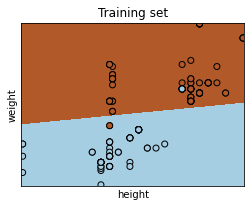

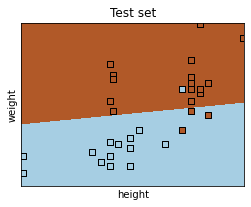

In [15]:
h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()

# 2) Linear Regression on the Boston House Price dataset

Dataset description: <br>
The Boston House Price Dataset involves the prediction of a house price in thousands of dollars given details about the house and its neighborhood.

The dataset contains a total of 500 observations, which relate 13 input features to an output variable (house price).

The variable names are as follows:

CRIM: per capita crime rate by town.

ZN: proportion of residential land zoned for lots over 25,000 sq.ft.

INDUS: proportion of nonretail business acres per town.

CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

NOX: nitric oxides concentration (parts per 10 million).

RM: average number of rooms per dwelling.

AGE: proportion of owner-occupied units built prior to 1940.

DIS: weighted distances to five Boston employment centers.

RAD: index of accessibility to radial highways.

TAX: full-value property-tax rate per $10,000.

PTRATIO: pupil-teacher ratio by town.

B: 1000*(Bk – 0.63)2 where Bk is the proportion of blacks by town.

LSTAT: % lower status of the population.

MEDV: Median value of owner-occupied homes in $1000s.
    

In [16]:
%matplotlib nbagg  

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import stats

In [17]:
#Import Data: Load the data from a .csv file

filename = "house.csv"
Data = np.genfromtxt(filename, delimiter=';',skip_header=1)

#A quick overview of data, to inspect the data you can use the method describe()

dataDescription = stats.describe(Data)
print(dataDescription)
print ("Shape of data array: " + str(Data.shape))



DescribeResult(nobs=500, minmax=(array([6.3200e-03, 0.0000e+00, 4.6000e-01, 0.0000e+00, 3.8500e-01,
       3.5610e+00, 2.9000e+00, 1.1296e+00, 1.0000e+00, 1.8700e+02,
       1.2600e+01, 3.2000e-01, 1.7300e+00, 5.0000e+01]), array([ 88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,   8.78  ,
       100.    ,  12.1265,  24.    , 711.    ,  22.    , 396.9   ,
        37.97  , 500.    ])), mean=array([3.65578576e+00, 1.15000000e+01, 1.11317400e+01, 7.00000000e-02,
       5.54451400e-01, 6.28297000e+00, 6.84246000e+01, 3.81193180e+00,
       9.64200000e+00, 4.09624000e+02, 1.84286000e+01, 3.56208040e+02,
       1.26987400e+01, 2.25680000e+02]), variance=array([7.47252195e+01, 5.48905812e+02, 4.76198228e+01, 6.52304609e-02,
       1.35838329e-02, 4.97618330e-01, 7.99314163e+02, 4.46304043e+00,
       7.59617595e+01, 2.85605197e+04, 4.67663531e+00, 8.41657137e+03,
       5.13361942e+01, 8.52982926e+03]), skewness=array([ 5.17851447,  2.19924065,  0.29469001,  3.37060575,  0.72944382,
        0

# Split data in training, validation and test sets



Given $m$ total data, denote with $m_{tv}$ the part used for training and validation. Keep $m_t$ data as training data, $m_{val}:=m_{tv}-m_t$ as validation data and $m_{test}:=m - m_{val} - m_t = m-m_{tv}$. For instance one can take $m_t=0.6m$ of the data as training, $m_{val}=0.2m$  validation and $m_{test}=0.2m$ as testing. Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{val}$ the validation data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

VALIDATION DATA: When different model classes are present (e.g. of different complexity such as linear regression which uses a different number $d_j$ of regressors $x_1$,...$x_{d_j}$), one has to choose which one is the "best" complexity. In this simple example the validation set is not needed, but it is better to get used with it.
Let ${\cal H}_{d_j}$ be the space of models as a function of the complexity $d_j$ and let 
$$
\hat h_{d_j} = {\rm arg\; min}_{h \in {\cal H}_{d_j}} \, L_S(h)
$$

One can estimate the generalization error for model $\hat h_{d_j}$ as follows:
$$
L_{{\cal D}}(\hat h_{d_j}) \simeq \frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$
and then choose the complexity which achieves the best estimate of the generalization error
$$
\hat d_j: = {\rm arg\; min}_{d_j} \,\frac{1}{m_{val}} \sum_{ z_i \in S_{val}} \ell(\hat h_{d_j},z_i)
$$

TESTING DATA: Last, the test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$



In [18]:
#get number of total samples
num_total_samples = Data.shape[0]

print ("Total number of samples: ", num_total_samples)

size_chunk = int(num_total_samples/5)

print ("Size of each chunk of data: ", size_chunk)

#shuffle the data
np.random.shuffle(Data)
np.random.shuffle(Data)


#training data 
#because data is randomised I'll use this simple way of separating data

X_training = Data[0:3*size_chunk,0:12]
Y_training = Data[0:3*size_chunk,12]
print ("Training input data size: ", X_training.shape)
print ("Training output data size: ", Y_training.shape)

#validation data, to be used to choose among different models
X_validation = Data[3*size_chunk:4*size_chunk,0:12]
Y_validation = Data[3*size_chunk:4*size_chunk,12]
print ("Validation input data size: ", X_validation.shape)
print ("Validation output data size: ", Y_validation.shape)

# #test data, to be used to estimate the true loss of the final model(s)
X_test = Data[4*size_chunk:5*size_chunk,0:12]
Y_test = Data[4*size_chunk:5*size_chunk,12]
print ("Test input data size: ", X_test.shape)
print ("Test output data size: ", Y_test.shape)

Total number of samples:  500
Size of each chunk of data:  100
Training input data size:  (300, 12)
Training output data size:  (300,)
Validation input data size:  (100, 12)
Validation output data size:  (100,)
Test input data size:  (100, 12)
Test output data size:  (100,)


# Data Normalization
It is common practice in Statistics and Machine Learning to scale the data (= each variable) so that it is centered (zero mean) and has standard deviation equal to 1. This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [19]:
#scale the data

# standardize the input matrix
from sklearn import preprocessing
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_validation = scaler.transform(X_validation) # use the same transformation on validation data
print ("Mean of the validation input data:", X_validation.mean(axis=0))
print ("Std of the validation input data:", X_validation.std(axis=0))

X_test = scaler.transform(X_test) # use the same transformation on test data
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Mean of the training input data: [-2.30001203e-16 -2.96059473e-17  3.28255941e-15  4.24845344e-16
 -3.82212780e-15  2.20934382e-16  5.97299987e-16  1.88552877e-15
 -6.32827124e-17 -1.81151390e-16  2.49555931e-14  5.05595565e-15]
Std of the training input data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean of the validation input data: [-0.05710448  0.09851731  0.00060545 -0.07838618 -0.0436047  -0.01680378
  0.13228837  0.03197276 -0.14832087 -0.07417851 -0.07869183  0.18314533]
Std of the validation input data: [0.90998696 1.18342612 1.00587982 0.85419359 0.95055702 1.03440261
 0.89598249 0.96068321 0.89822825 0.91377605 1.1054354  0.67235716]
Mean of the test input data: [-0.00779114 -0.04627885  0.17361355  0.07838618  0.14179563  0.07306848
  0.17321814 -0.14280406  0.11729457  0.12047459  0.02185884 -0.02791406]
Std of the test input data: [0.71040572 0.96230526 1.03087246 1.12163475 0.91764188 1.26707405
 1.01632367 0.95082524 1.02057005 0.98712728 1.13063317 1.04319264]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$.


 

In [20]:
#compute linear regression coefficients for training data


#add a 1 at the beginning of each sample for training, validation, and testing (use homogeneous coordinates)
m_training = X_training.shape[0]
X_trainingH = np.hstack((np.ones((m_training,1)),X_training)) # H: in homogeneous coordinates


m_validation = X_validation.shape[0]
X_validationH = np.hstack((np.ones((m_validation,1)),X_validation))  # H: in homogeneous coordinates


m_test = X_test.shape[0]
X_testH = np.hstack((np.ones((m_test,1)),X_test))  # H: in homogeneous coordinates
  

# Compute the least-squares coefficients using linalg.lstsq
w_np, RSStr_np, rank_Xtr, sv_Xtr =  np.linalg.lstsq(X_trainingH,Y_training,rcond=None)
print("LS coefficients with numpy lstsq:", w_np)


# compute Residual sums of squares
RSStr_hand = 0
for i in range(len(Y_training)):
    RSStr_hand += (Y_training[i] - sum(X_trainingH[i].T*w_np))**2
    
print("RSS calculated by hand: ", RSStr_hand)
print("RSS with numpy lstsq: ", RSStr_np)
print("Empirical risk with numpy lstsq:", RSStr_np/m_training)

LS coefficients with numpy lstsq: [12.70956667  0.35043687  0.49129734  0.79014799 -0.51003291  0.4395422
 -3.38201173  2.57793414 -0.02905018  0.85191811 -0.46007333  0.11017639
 -0.77928314]
RSS calculated by hand:  4595.260758363394
RSS with numpy lstsq:  [4595.26075836]
Empirical risk with numpy lstsq: [15.31753586]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS). 

In [21]:
#compute predictions on training and validation

#prediction_training
prediction_training = np.array([])

for i in range(len(Y_training)):
    prediction_training = np.append(prediction_training, np.dot(X_trainingH,w_np))


prediction_validation = np.array([])
prediction_validation = np.append(prediction_validation, np.dot(X_validationH,w_np))


prediction_test = np.array([])
prediction_test = np.append(prediction_test, np.dot(X_testH,w_np))


# #what about the loss for points in the validation data?
RSS_validation = 0
for i in range(len(Y_validation)):
    RSS_validation += (Y_validation[i] - prediction_validation[i])**2
    

RSS_test = 0
for i in range(len(Y_test)):
    RSS_test += (Y_test[i] - prediction_test[i])**2

print("RSS on validation data:",  RSS_validation)
print("Loss estimated from validation data:", RSS_validation/m_validation)

print("RSS on test data:",  RSS_test)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on validation data: 1447.830413543474
Loss estimated from validation data: 14.478304135434739
RSS on test data: 2820.9457492489646
Loss estimated from test data: 28.209457492489648


## Ordinary Least-Squares using scikit-learn
Another fast way to compute the LS estimate is through sklearn.linear_model (for this function homogeneous coordinates are not needed).

In [22]:
from sklearn import linear_model

# build the LinearRegression() model and train it
LinReg = linear_model.LinearRegression()
LinReg.fit(X_training,Y_training)



print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)

# predict output values on training and test sets

prediction_training = LinReg.predict(X_training)

prediction_test = LinReg.predict(X_test)


# just to make sure that the test error is the same
RSS_test = 0
for i in range(len(Y_test)):
    RSS_test += (Y_test[i] - prediction_test[i])**2
print("Loss estimated from test data (LinReg version)", RSS_test/m_test)


# return a prediction score based on the coefficient of determination
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))

Intercept: 12.709566666666666
Least-Squares Coefficients: [ 0.35043687  0.49129734  0.79014799 -0.51003291  0.4395422  -3.38201173
  2.57793414 -0.02905018  0.85191811 -0.46007333  0.11017639 -0.77928314]
Loss estimated from test data (LinReg version) 28.20945749248966
Measure on training data: 0.3020252159048825
